# Import required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
import pickle
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Import assets

In [2]:
mat_content = sio.loadmat('assets/face.mat')
print(type(mat_content['X']))
len(set(mat_content['l'][0]))

<class 'numpy.ndarray'>


52

# Split into training and testing sets

In [3]:
def train_test_split_by_n(n, image_data, data_label, test_size = 0.2):
    for i in range(0, len(image_data), 10):
        each_face_sample = image_data[i:i+10, :]
        each_face_label = data_label[i:i+10]
        X_train, X_test, y_train, y_test = train_test_split(each_face_sample, each_face_label, test_size=test_size)
        if i == 0:
            X_train_res = X_train
            X_test_res = X_test
            y_train_res = y_train
            y_test_res = y_test
        else:
            X_train_res = np.append(X_train_res, X_train, axis=0)
            X_test_res = np.append(X_test_res, X_test, axis=0)
            y_train_res = np.append(y_train_res, y_train)
            y_test_res = np.append(y_test_res, y_test)
            
    return X_train_res, X_test_res, y_train_res, y_test_res

image_data = mat_content['X'].T
print(image_data.shape)

data_label = mat_content['l'][0].T
print(data_label.shape)

train_test_split_by_n(10, image_data, data_label)

X_train, X_test, y_train, y_test = train_test_split_by_n(10, image_data, data_label, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

train_image = X_train.T
train_label = y_train.T

test_image = X_test.T
test_label = y_test.T


(520, 2576)
(520,)
(416, 2576)
(104, 2576)


# Functions

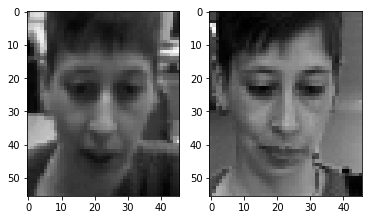

In [4]:
def select_image_by_label(l: int, label: list, image: list):
    col_indices = np.where(label == l)
    images = image[:, col_indices]
    return images.reshape(images.shape[0], images.shape[2])

def plot_face(face):
    plt.imshow(np.reshape(face,(46,56)).T, cmap = 'gist_gray')

def plot_all_faces(faces):
    n = faces.shape[1]
    if n == 0:
        print('No Image')
        return None
    n_of_rows = math.ceil(n / 2)
    for i in range(n):
        plt.subplot(n_of_rows, 2, i+1), plot_face(faces[:, i])

def nn_classifier(w_training, training_label, m_eigvecs, mean_image, face_image):
    # map test image onto eigenspace
    # normalize
    phi = face_image - mean_image
    # project on the eigenspace and represent the projection as w
    w = np.dot(m_eigvecs.T, phi)
    # calculate the distance 
    dist = np.linalg.norm(w_training - w, axis=1) 
    return training_label[np.argmin(dist)]

def compute_s_b(face, face_label, face_avg):
    df = pd.DataFrame(face.T, index=face_label)
    grouped_mean = df.groupby(df.index).mean()
    m_i_m = grouped_mean - face_avg
    sb = np.dot(m_i_m.T, m_i_m)
    return sb

def compute_s_w(face, face_label, face_avg):
    df = pd.DataFrame(face.T, index=face_label)
    grouped = df.groupby(df.index)
    grouped_mean = grouped.mean()
    # use loc to select row by label
    # use iloc to select row by index
    list_x = []
    for key, table in grouped:
        x_m_i = table - grouped_mean.loc[key, :]
        np_xmi = np.dot(x_m_i.values.T, x_m_i.values)
        list_x.append(np_xmi)
    
    return sum(list_x)

def calc_accuracy(test_image, test_label, a, train_label, m_eigvecs, face_avg):
    pred_label = list(map(lambda k: nn_classifier(a, train_label, m_eigvecs, face_avg, k), test_image.T))
    acc = accuracy_score(test_label, pred_label)
    cm = confusion_matrix(test_label, pred_label)
    plt.matshow(cm, cmap="Blues")
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    return f"Accuracy: {acc:.2f}"

images = select_image_by_label(11, test_label, test_image)
plot_all_faces(images)

plt.show()

# Cache data with Pickle

In [5]:
PIK = 'pickle_cov.dat'

def write_to_pickle(data):
    with open(PIK, 'wb') as f:
        pickle.dump(data, f)

def read_from_pickle():
    with open(PIK, 'rb') as f:
        pickle.load(f)
    

# PCA
## Use eigen values and eigen vectors 

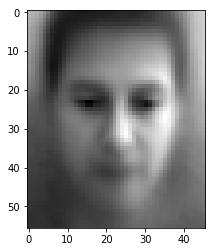

In [6]:
def compute_avg_face(face_list, axis=1):
    face_avg = np.mean(face_list, axis=axis)
    return face_avg

def compute_cov_face(face_list, N):
    return np.dot(face_list, face_list.T) / N

face_avg = compute_avg_face(train_image)
phi_face = train_image - face_avg.reshape(face_avg.shape[0], 1)

plot_face(face_avg)
m, N = phi_face.shape

s = compute_cov_face(phi_face, N) # Utilise broadcasting to deduct row by row

s_small = compute_cov_face(phi_face.T, N)

eigvals, eigvecs = np.linalg.eig(s) 
eigvals_small, eigvecs_small = np.linalg.eig(s_small)

u_i = phi_face.dot(eigvecs_small)
norm_u_i = np.linalg.norm(u_i, axis=0)
eigvecs_small = u_i / norm_u_i

In [7]:
# print('Eigen values big: ', eigvals[: 10])
# print('Eigen values small: ', eigvals_small[: 10])

# print('Eigen vectors big: ', eigvecs.real[:10])
# print('Eigen vectors small: ', eigvecs_small[:10])

print(eigvecs.shape)
print(eigvecs_small.shape)
print(m, N)

(2576, 2576)
(2576, 416)
2576 416


# Plot a graph of Eigen values against number of columns

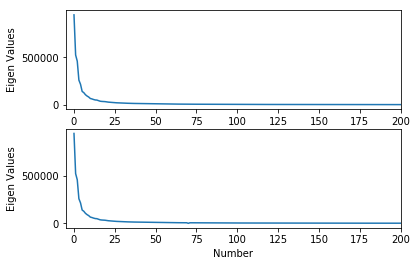

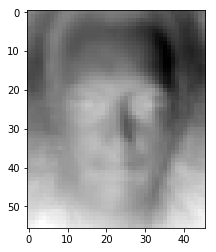

In [8]:
plt.subplot(211), plt.plot(eigvals.real), plt.xlabel('Number'), plt.ylabel('Eigen Values'), plt.xlim([-5, 200])
plt.subplot(212), plt.plot(eigvals_small), plt.xlabel('Number'), plt.ylabel('Eigen Values'), plt.xlim([-5, 200])

plt.show()

plot_face(((eigvecs[:, 0].real)))

(416, 200)
x_n: (416, 2576)
(2576,)
(200,)


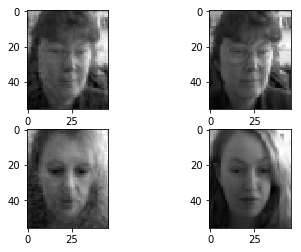

In [9]:
m_eigvecs = eigvecs_small[:, :200]
a = np.dot(phi_face.T, m_eigvecs)
print(a.shape)
x_n = face_avg + a.dot(m_eigvecs.T)
print('x_n:', x_n.shape)
# Training image
plt.subplot(221), plot_face(x_n[0, :].T.real)
plt.subplot(222), plot_face(train_image[:, 0])

a_test = m_eigvecs.T.dot(test_image[:, 3])
x_test = face_avg + a_test.dot(m_eigvecs.T)
print(x_test.shape)

# Testing image
plt.subplot(223), plot_face(x_test.T.real)
plt.subplot(224), plot_face(test_image[:, 3])

print(a_test.shape)
plt.show()

# Nearest Neighbor (NN) Classifier

14 3
Accuracy: 0.56


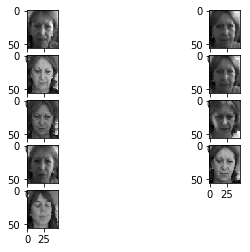

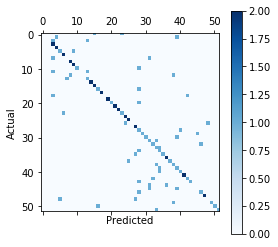

In [10]:
face_image = test_image[:, 4]
predicted_label = nn_classifier(a, train_label, m_eigvecs, face_avg, face_image)
print(predicted_label, test_label[4])

images = select_image_by_label(predicted_label, train_label, train_image)

f = face_image.reshape(face_image.shape[0], 1)
all_images = np.hstack((images, f))
plot_all_faces(all_images)

acc = calc_accuracy(test_image, test_label, a, train_label, m_eigvecs, face_avg)
print(acc)

# Alternative Method

In [11]:
def calc_eig_pca(train_image):
    face_avg = compute_avg_face(train_image)
    phi_face = train_image - face_avg.reshape(face_avg.shape[0], 1)

    m, N = phi_face.shape

    s = compute_cov_face(phi_face, N)
    # s_small = compute_cov_face(phi_face.T, N)
    eigvals, eigvecs = np.linalg.eig(s)
    # eigvals_small, eigvecs_small = np.linalg.eig(s_small)
    return eigvals, eigvecs

def calc_eig_pca_small(train_image):
    """
    Always return the smaller, normalised version of eigen vectors and eigen values
    """
    m, N = train_image.shape
    if N < m:
        face_avg = compute_avg_face(train_image)
        phi_face = train_image - face_avg.reshape(face_avg.shape[0], 1)
        s = compute_cov_face(phi_face.T, N)
        
        eigvals, eigvecs = np.linalg.eig(s)

        u_i = phi_face.dot(eigvecs)
        norm_u_i = np.linalg.norm(u_i, axis=0)
        eigvecs = u_i / norm_u_i
        return eigvals, eigvecs
    # If there are more features than the number of samples
    else:
        return calc_eig_pca(train_image)

def alternative_method(training_image, train_label, m, face_image):
    df = pd.DataFrame(training_image.T, index=train_label)    
#     grouped_mean = df.groupby(df.index).mean()
    grouped = df.groupby(df.index)

    min_e = float('inf')
    min_label = df.index[0]
    for key, tab in grouped:
        # Compute Principle (eigen) subspace per class
        train_image = tab.values.T
        
        eigvals, u_i = calc_eig_pca_small(train_image)
        u_i = u_i[:, :m]
        # Classification
        face_mean = compute_avg_face(train_image)
#         print(compute_avg_face(train_image).shape, face_image.shape)
        phi = face_image - face_mean
        
        w = np.dot(phi.T, u_i)
        x_n = face_mean + np.dot(u_i, w)

        e = np.linalg.norm(face_image - x_n)
        if e < min_e:
            min_label = key
            min_e = e
    return min_label

correct = 0
total = test_label.size
# i = 5
# face_image = test_image[:, i]
# predicted_label = alternative_method(train_image, train_label, face_image)
# print(predicted_label, test_label[i])

for i in range(0, total):
    face_image = test_image[:, i]
    predicted_label = alternative_method(train_image, train_label, 100, face_image)
    if predicted_label == test_label[i]:
        correct += 1

print(f'Accuracy of alternative method: {correct / total * 100:.2f}%')

Accuracy of alternative method: 61.54%


# LDA 
## Fisherfaces

### Compute S_w, S_b

In [12]:
import pandas as pd

M, N = train_image.shape
c = len(set(train_label))
    
sb = compute_s_b(train_image, train_label, face_avg)
sw = compute_s_w(train_image, train_label, face_avg)
print(sb.shape, sw.shape)

(2576, 2576) (2576, 2576)


### Compute eigvalues, eigenvectors of S_w, S_b

We need to use pseudoinverse for sw because sw is often singular, since the rankof sw is at most N-c (c = Number of labels), and in general, N (Number of samples) is smaller than D (dimension of image).

In [13]:
m = np.dot(np.linalg.pinv(sw), sb)
eigvals_lda, eigvecs_lda = np.linalg.eig(m)
# eigvals, eigvecs = np.linalg.eig()

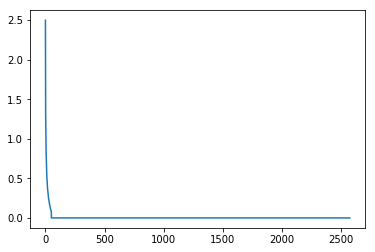

In [14]:
plt.plot(eigvals_lda.real)
plt.show()

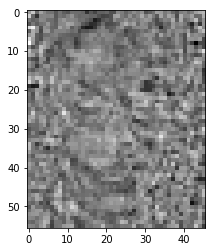

In [15]:
plot_face(eigvecs_lda[:, 0].real)

## Reduce dimension of sw, sb using PCA

In [16]:
wsww = np.dot(m_eigvecs.T, np.dot(sw, m_eigvecs)) # Refer to page 24 of Discriminate Analysis Fisherface lecture
wsbw = np.dot(m_eigvecs.T, np.dot(sb, m_eigvecs))
pca_mat = np.dot(np.linalg.pinv(wsww), wsbw)

eigvals_fld, eigvecs_fld = np.linalg.eig(pca_mat)

In [17]:
np.linalg.matrix_rank(eigvecs_fld)

200

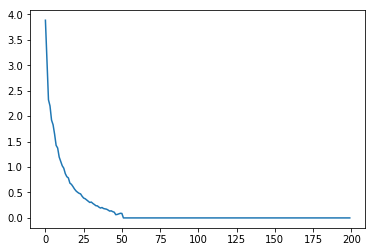

In [18]:
plt.plot(eigvals_fld.real)
plt.show()

# Predict using NN Classifier

(200, 50)
(2576, 200)
(416, 200) (2576, 50)
6 6
Accuracy: 0.81


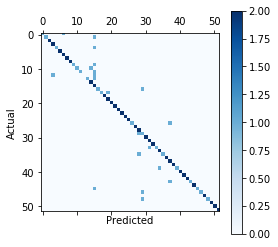

In [19]:
i = 11
face_image = test_image[:, i]
m_eigvecs_fld = eigvecs_fld[:, :50]
print(m_eigvecs_fld.shape)
print(m_eigvecs.shape)
w_opt = np.dot(m_eigvecs_fld.T, m_eigvecs.T).T.real

print(a.shape, w_opt.shape)
a_fld = np.dot(phi_face.T, w_opt)

predicted_label = nn_classifier(a_fld, train_label, w_opt, face_avg, face_image)
print(predicted_label, test_label[i])


acc_fld = calc_accuracy(test_image, test_label, a_fld, train_label, w_opt, face_avg)
print(acc_fld)